# Кластеризация. Метод K-Means. Домашнее задание

## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [58]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import math

In [22]:
# загружаем данные
df = pd.read_csv('Mall_Customers (1).csv').drop('CustomerID', axis=1)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [23]:
df.shape

(200, 4)

In [24]:
# Проверим наличие пропусков
df.isna().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [25]:
# описание признаков
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.97,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.26,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.82,1.0,34.75,50.0,73.0,99.0


In [62]:
# функция для гистограммы
def plot_hist(data):
# Список цветов для гистограмм
    color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Количество признаков в данных
    num_features = len(data.columns)
    
    # Определяем количество строк и столбцов для подграфиков
    num_cols = 2  
    num_rows = math.ceil(num_features / num_cols)
    
    # Создаем фигуру с необходимым количеством подграфиков
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axs = axs.flatten()  # "Разворачиваем" массив подграфиков в плоский массив
    
    for i, ax in enumerate(axs):
        if i < num_features:
            # Создаем гистограмму для каждого признака
            sns.histplot(data[data.columns[i]], bins=40, kde=True, color=color_list[i % len(color_list)], ax=ax)
            ax.set_title(f'Распределение {data.columns[i]}')
            ax.set_xlabel(data.columns[i])
            ax.set_ylabel('Частота')
        else:
            # Убираем лишние пустые подграфики
            ax.axis('off')
    
    # Подгоняем расположение элементов
    plt.tight_layout()
    plt.show()

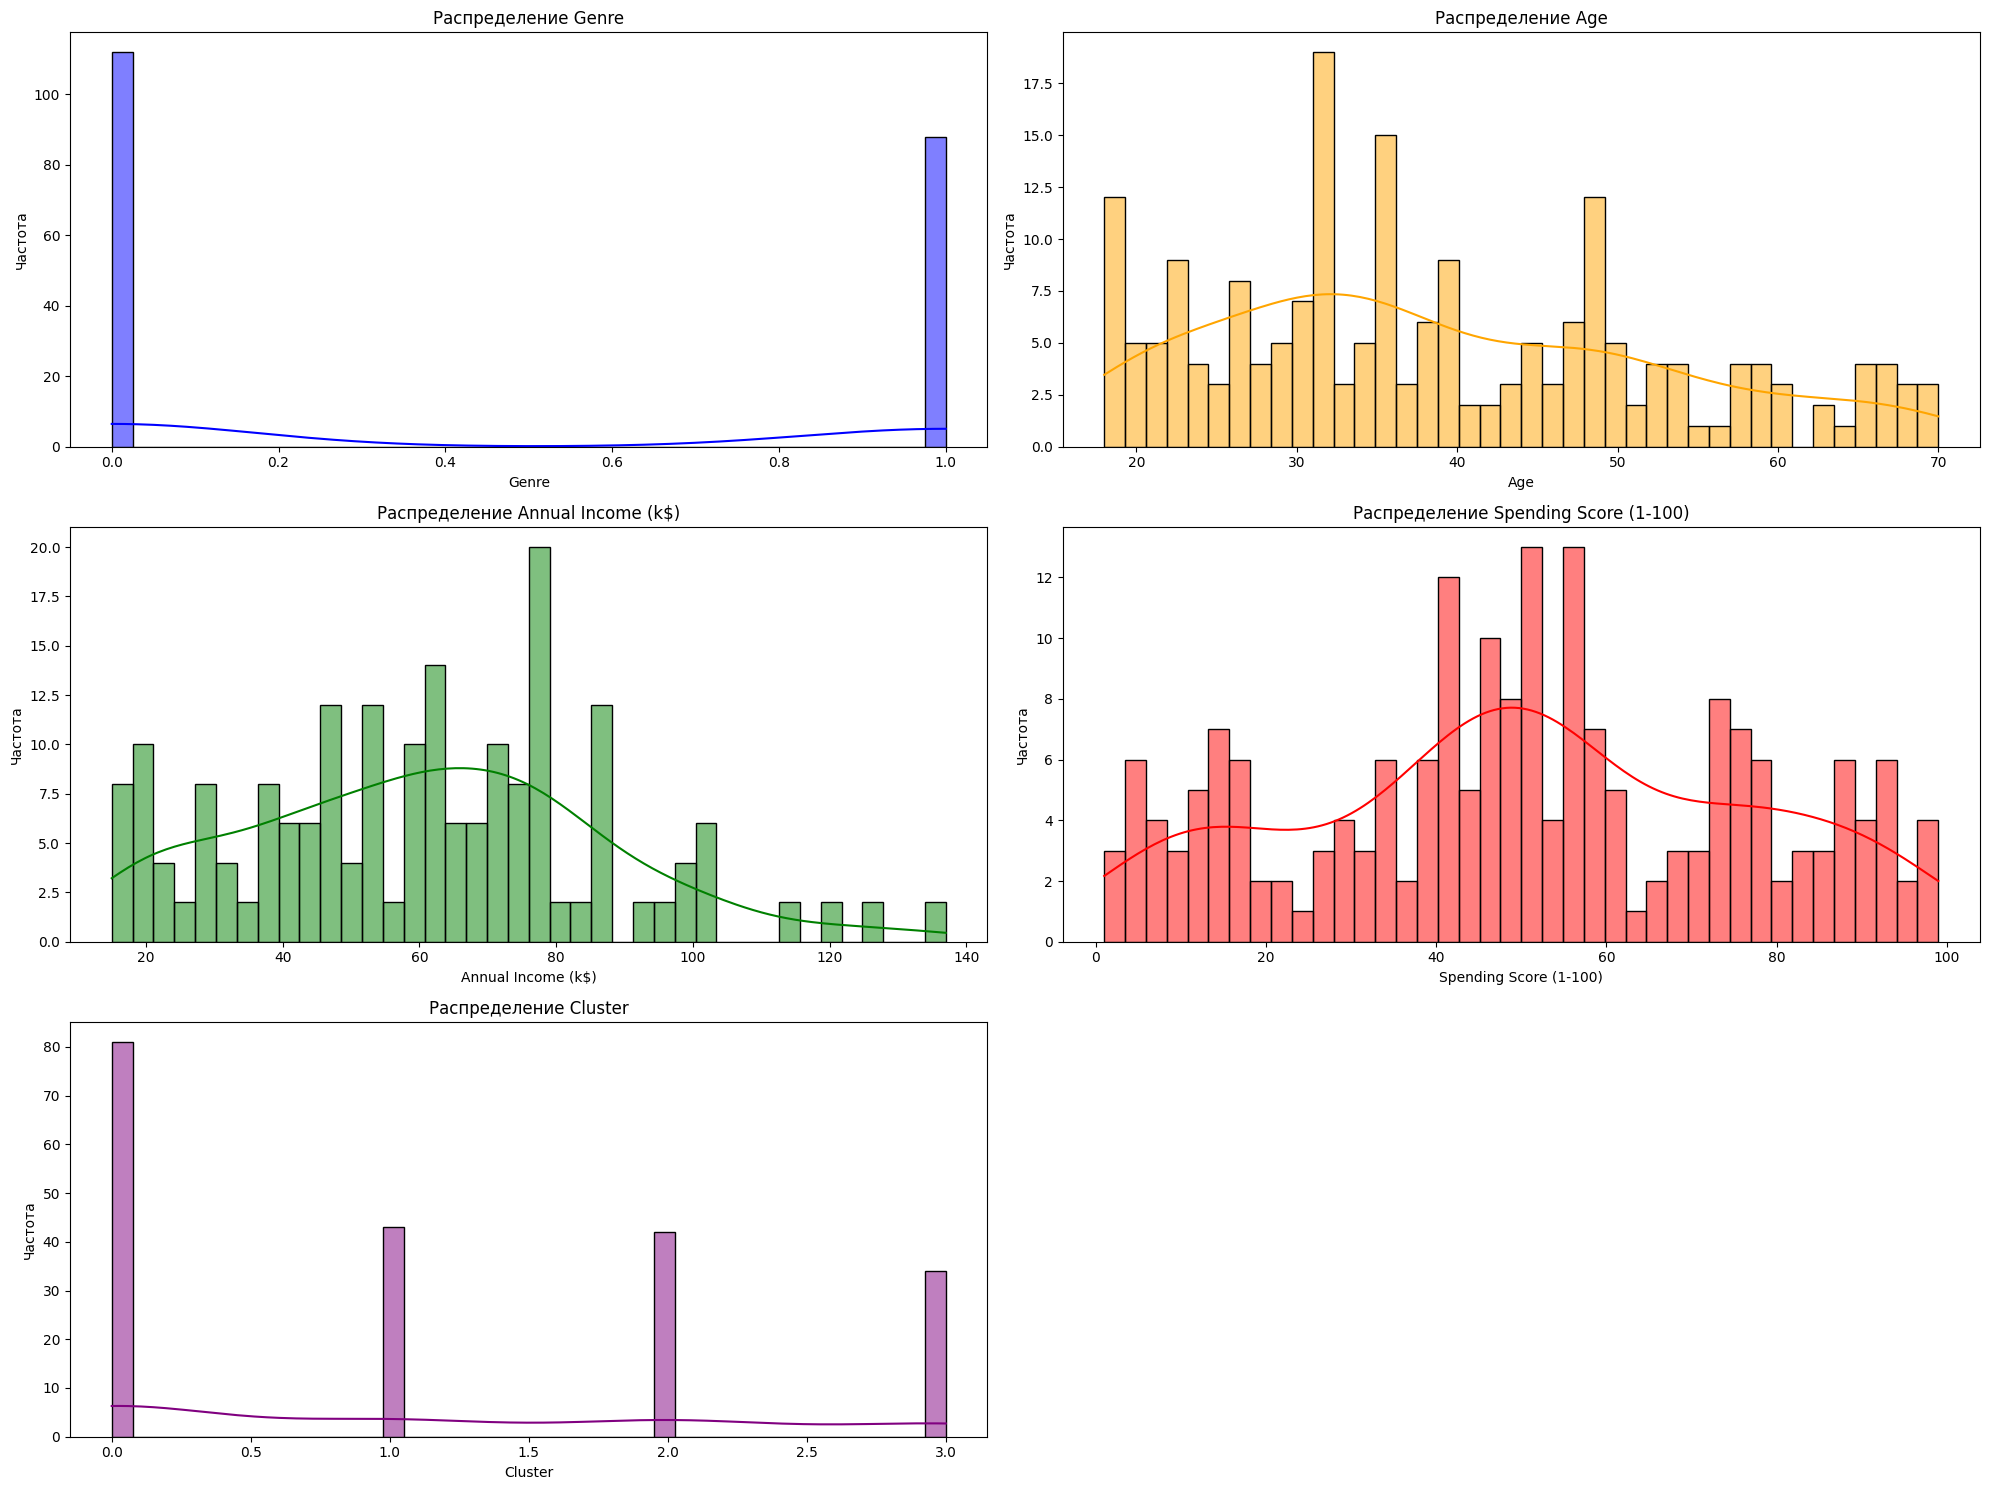

In [64]:
# Визуализируем данные
plot_hist(df)

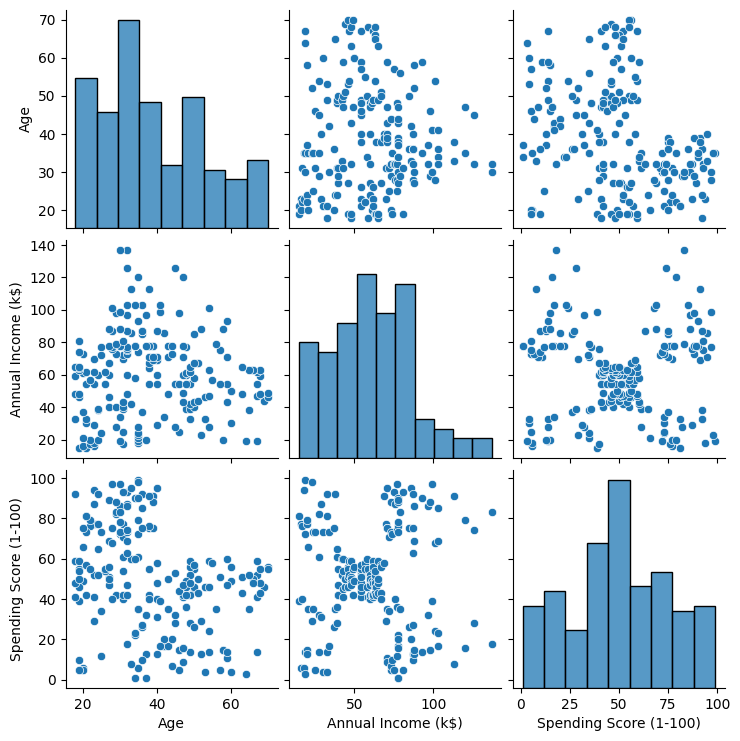

In [27]:
sns.pairplot(df)
plt.show()

**Выводы:**
- Пропуски отсутствуют
- Выбросы отсутствуют 
- Между переменными не наблюдается четких линейных корреляций. Но можно заметить, что люди среднего возраста (30-50 лет) в среднем имеют более высокий доход, чем более молодые или более пожилые.
- Можно увидеть в разделение на кластеры между Annual Income (k$) и Spending Score (1-100)

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

**Вывод:**
- На основе визуального анализа можно сделать вывод, что оптимальное количество кластеров для данных в данном случае равно 5.

### Задание 3

Преобразуйте категориальный признак Genre в численный.

In [28]:
# Закодируем признак Genre
encoder = LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

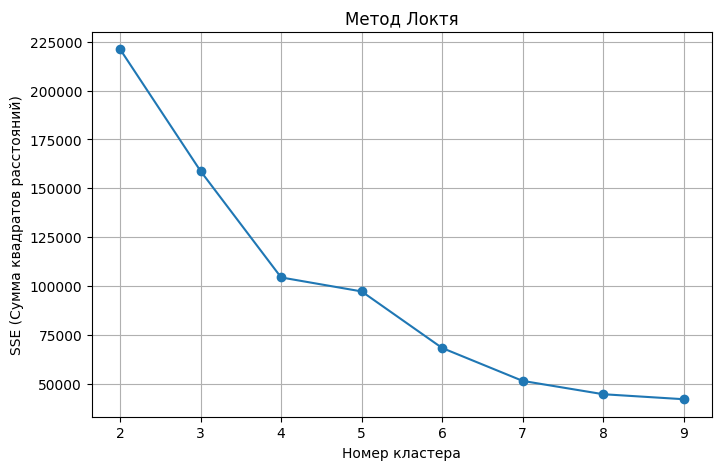

In [29]:
# Создаем список для хранения значений инерции
sse = []
range_n_clusters = range(2, 10)

# Проходим по различным значениям k
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

# Построение графика метода "локтя"
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, sse, marker='o')
plt.xlabel('Номер кластера')
plt.ylabel('SSE (Сумма квадратов расстояний)')
plt.title('Метод Локтя')
plt.grid(True)
plt.show()

**Вывод:**
- На основе анализа, с помошью метода локтя, можно сделать вывод, что оптимальное количество кластеров для данных равно 4.

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

In [42]:
# Масштабирование данных
scaler = StandardScaler()
X = df
X_scaled = scaler.fit_transform(X)

In [48]:
# Создание и обучение модели
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

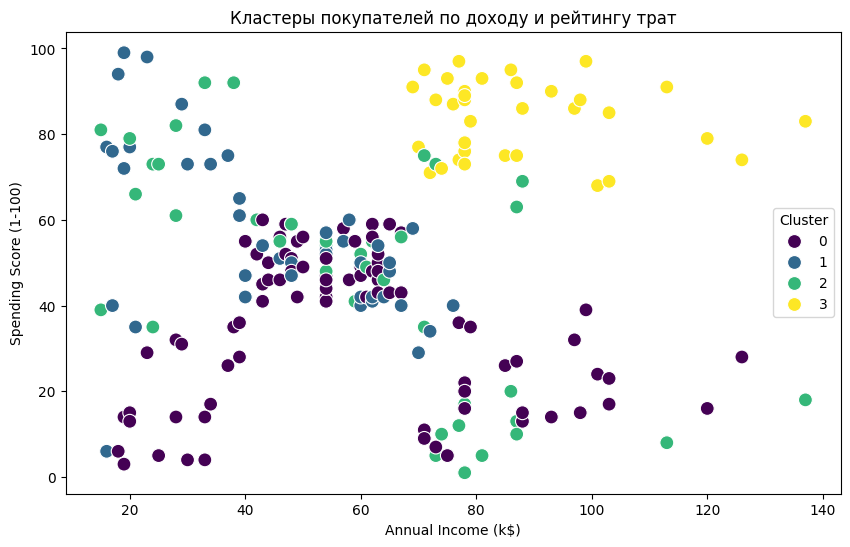

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'],
                hue=df['Cluster'], palette='viridis', s=100)
plt.title('Кластеры покупателей по доходу и рейтингу трат')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.

In [53]:
# Шаг 1: Загрузка данных
data = pd.read_csv('gt_2015.csv')
data.head()


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [54]:
data.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [55]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
AT,7384.0,17.23,8.10,-6.23,11.07,17.46,23.68,37.10
AP,7384.0,1014.51,6.90,989.40,1009.68,1014.00,1018.30,1036.60
AH,7384.0,68.65,13.54,24.08,59.45,70.95,79.65,96.67
AFDP,7384.0,3.60,0.61,2.37,3.12,3.54,4.19,5.24
GTEP,7384.0,26.13,4.47,17.70,23.15,25.33,30.02,40.72
TIT,7384.0,1078.97,19.76,1016.00,1070.50,1080.30,1099.90,1100.40
TAT,7384.0,546.64,5.49,516.04,544.75,549.72,550.03,550.59
TEY,7384.0,133.99,16.18,100.02,126.26,131.60,147.16,179.50
CDP,7384.0,12.10,1.14,9.87,11.47,11.93,13.15,15.16
CO,7384.0,3.13,2.23,0.21,1.81,2.53,3.70,41.10


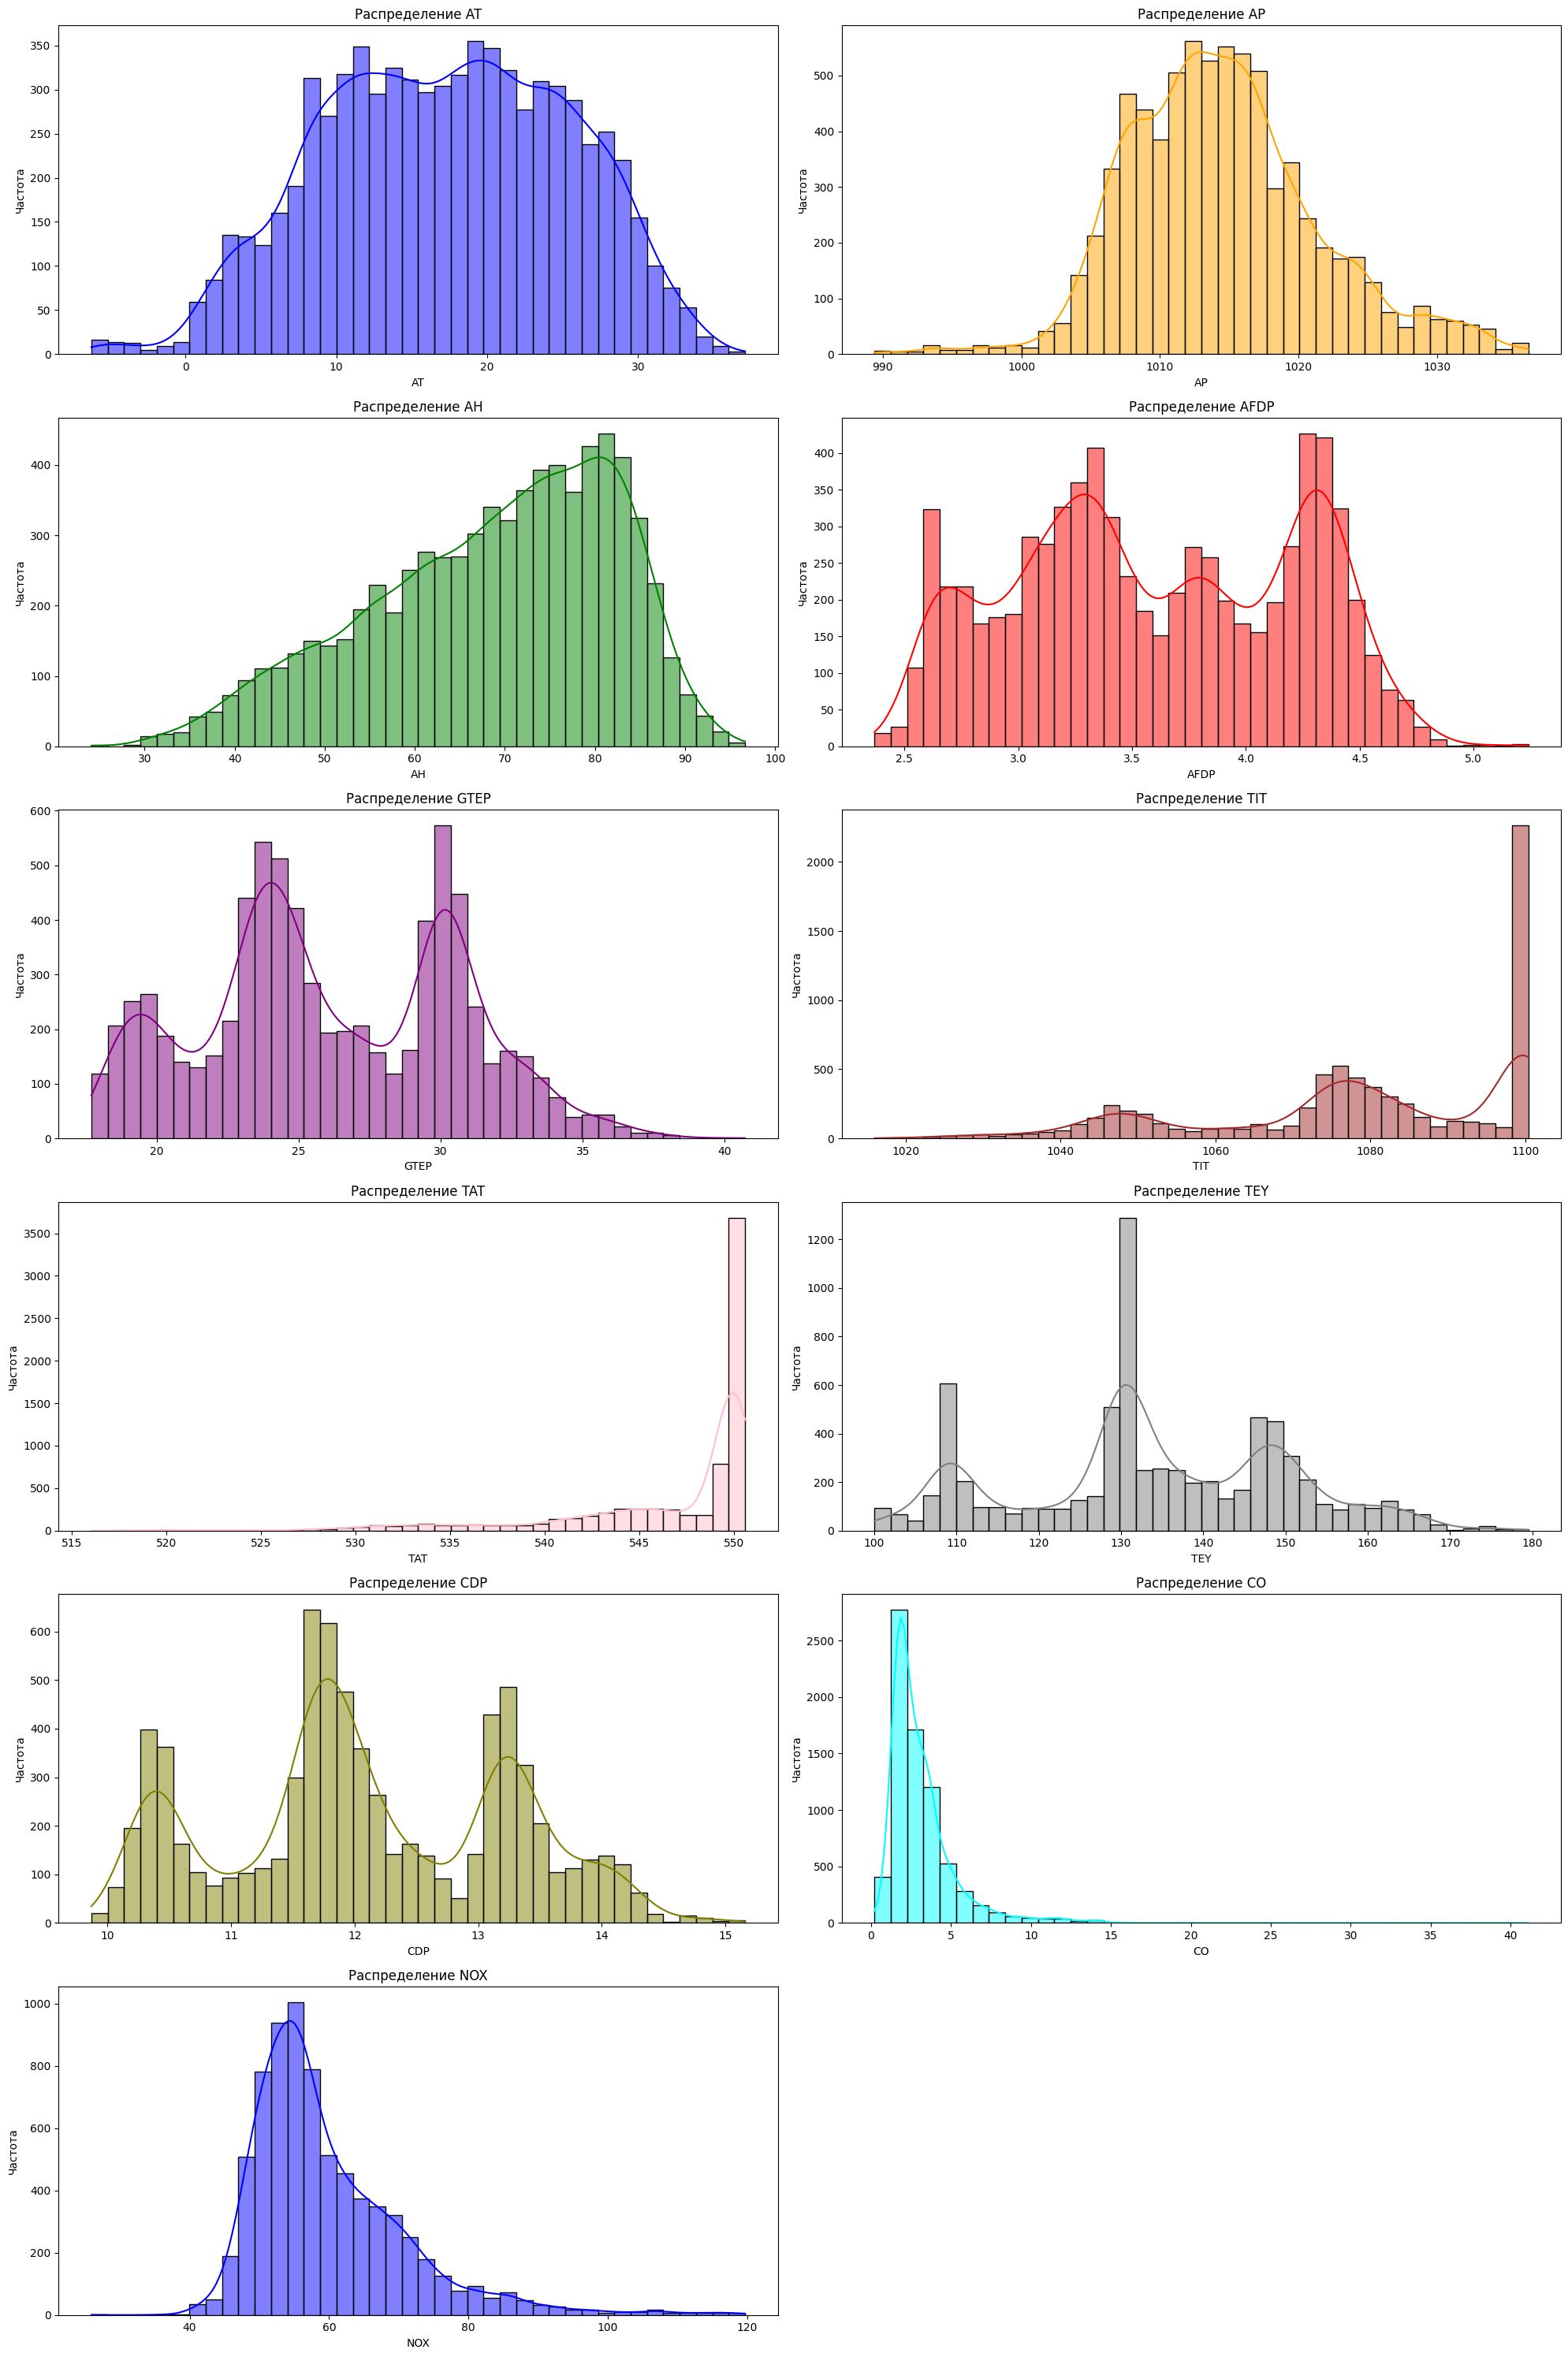

In [65]:
plot_hist(data)